In [1]:
!python --version

Python 3.10.0


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import image_dataset_from_directory
import shutil 
import pathlib
import tensorflow as tf
import sys 
from sklearn.metrics import r2_score, mean_squared_error
import pickle 
import seaborn as sns
import time
from keras import backend
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
from matplotlib.colors import LinearSegmentedColormap

# Definición de colores para las futuras gráficas

In [3]:
d_blue = '#000078'
l_blue = '#73EDFF'
green = '#38FF90'
yellow = '#FFE000'
red = '#FF7D87'
purple = '#BD9EFF'
pink = '#FF87FF'

s_l_blue = '#D6FAFF'
s_gree = '#C2FFDE'
s_yellow = '#FFF5B2'
s_red = '#FFD9DB'
s_purple = '#EBE3FF'
s_pink = '#FFDBFF'

l_gray = '#F0F0F0'
m_gray = '#D0D0D0'
d_gray = '#878787'

# Comprensión de los datos

## Extracción de los datos de los titulos

In [4]:
# Crear un DataFrame para almacenar información del nombre del archivo
df = pd.read_csv("image_labels.csv")


# Guardar el número de filas
n_rows = df.shape[0]

### Comprobación de la imagen y la etiqueta

(-0.5, 191.5, 191.5, -0.5)

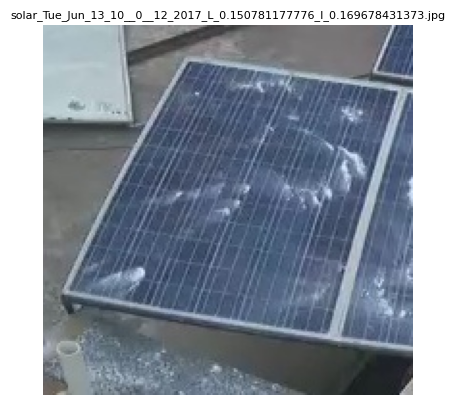

In [5]:
file_name = df['filename'].iloc[0]
images_dir = '../TFM/Solar_Panel_Soiling_Image_dataset/PanelImages'
image_path = os.path.join(images_dir, file_name)

image_bgr = cv2.imread(image_path)
# Convierte la imagen a formato RGB
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Muestra la imagen y agrega el nombre del archivo como título
plt.imshow(image)
plt.title(file_name, fontsize=8)
plt.axis('off')

## Análisis de los datos de las etiquetas

In [6]:
# Visualizar las primeras filas del DataFrame
print(df.head())
print('\n')

# Visualizar información del Dataframe
print(df.info())
print('\n')

# Visualizar información estadística sobre el DataFrame
df.describe()

                                            filename  solar day_of_week month  \
0  solar_Tue_Jun_13_10__0__12_2017_L_0.1507811777...  solar         Tue   Jun   
1  solar_Tue_Jun_13_10__0__18_2017_L_0.1507811777...  solar         Tue   Jun   
2  solar_Tue_Jun_13_10__0__2_2017_L_0.14720963921...  solar         Tue   Jun   
3  solar_Tue_Jun_13_10__0__23_2017_L_0.1544552142...  solar         Tue   Jun   
4  solar_Tue_Jun_13_10__0__28_2017_L_0.1544552142...  solar         Tue   Jun   

   day  hour  min  sec   time  year                 date      loss  \
0   13    10    0   12  36012  2017  2017-Jun-13 10:0:12  0.150781   
1   13    10    0   18  36018  2017  2017-Jun-13 10:0:18  0.150781   
2   13    10    0    2  36002  2017   2017-Jun-13 10:0:2  0.147210   
3   13    10    0   23  36023  2017  2017-Jun-13 10:0:23  0.154455   
4   13    10    0   28  36028  2017  2017-Jun-13 10:0:28  0.154455   

   irradiation  
0     0.169678  
1     0.169678  
2     0.170545  
3     0.167902  
4     0

,day,hour,min,sec,time,year,loss,irradiation
count,45754.000000,45754.000000,45754.000000,45754.000000,45754.000000,45754.0,45754.000000,45754.000000
mean,21.025025,11.808672,28.844888,29.563841,44271.477991,2017.0,0.265098,0.345781
std,5.434381,3.120193,17.343180,17.403341,11239.017714,0.0,0.284057,0.206151
min,13.000000,6.000000,0.000000,0.000000,21605.000000,2017.0,0.000000,0.002682
25%,15.000000,9.000000,14.000000,14.000000,35728.250000,2017.0,0.031738,0.189629
50%,22.000000,12.000000,28.000000,29.000000,43773.000000,2017.0,0.119817,0.310786
75%,26.000000,15.000000,44.000000,45.000000,54109.750000,2017.0,0.522474,0.483816
max,30.000000,17.000000,59.000000,59.000000,64748.000000,2017.0,0.996159,1.006125


In [7]:
# Convertir date en tipo datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%b-%d %H:%M:%S')

# Ordena el DataFrame por la columna 'date'
df = df.sort_values(by='date')
df.head()

,filename,solar,day_of_week,month,day,hour,min,sec,time,year,date,loss,irradiation
3339,solar_Tue_Jun_13_9__46__49_2017_L_0.0474843723...,solar,Tue,Jun,13,9,46,49,35209,2017,2017-06-13 09:46:49,0.047484,0.296733
3340,solar_Tue_Jun_13_9__46__54_2017_L_0.0273312333...,solar,Tue,Jun,13,9,46,54,35214,2017,2017-06-13 09:46:54,0.027331,0.288831
3341,solar_Tue_Jun_13_9__46__59_2017_L_0.0273312333...,solar,Tue,Jun,13,9,46,59,35219,2017,2017-06-13 09:46:59,0.027331,0.288831
3342,solar_Tue_Jun_13_9__47__4_2017_L_0.03979859380...,solar,Tue,Jun,13,9,47,4,35224,2017,2017-06-13 09:47:04,0.039799,0.300631
3344,solar_Tue_Jun_13_9__47__9_2017_L_0.03979859380...,solar,Tue,Jun,13,9,47,9,35229,2017,2017-06-13 09:47:09,0.039799,0.300631


### Análisis explorarorio de las imágenes

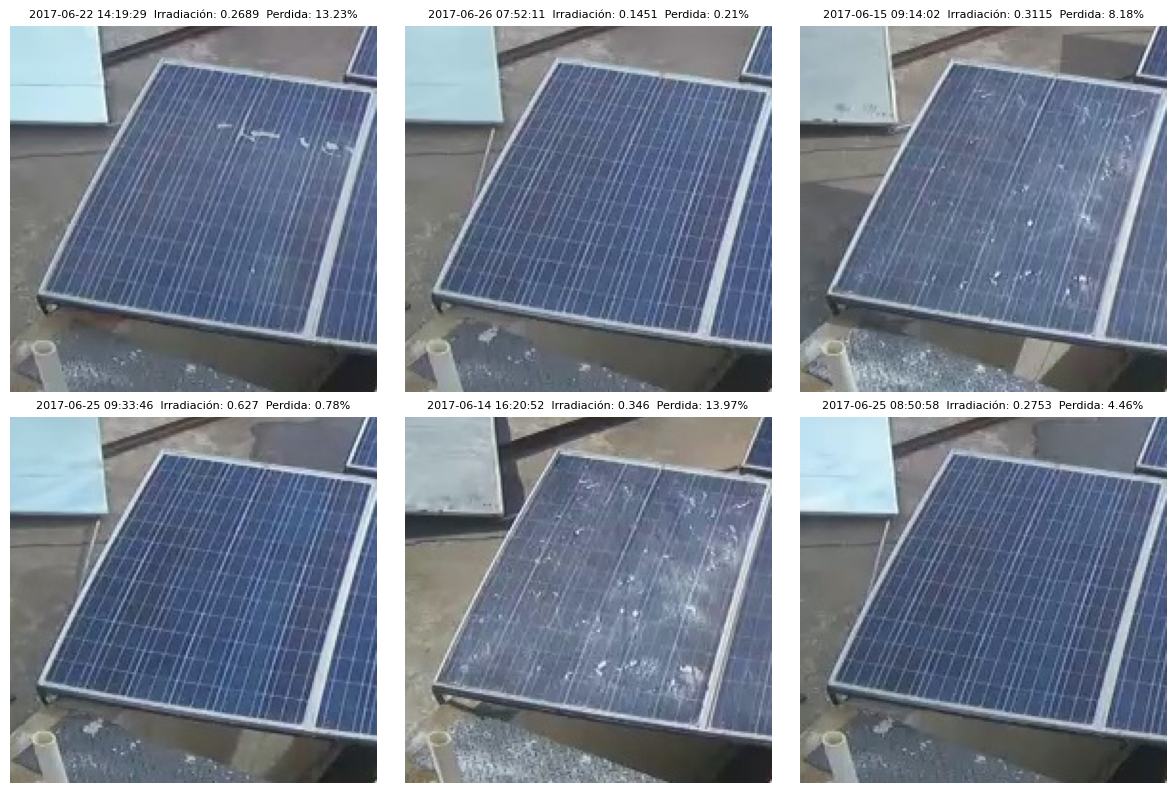

Valor mínimo de las imágenes: 7
Valor máximo de las imágenes: 255
Dimensión de las imágenes: (192, 192, 3)


In [8]:
# Función para mostrar algunas imágenes de ejemplo
# y las carácteristicas de las imagenes
def show_images_sample():
    min_value = 1_000
    max_value = 0

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(2):
        for j in range(3):
            # Obten un ejemplo de forma aleatoria
            image_sample = df.sample()

            # Obtén el nombre de archivo
            file_name = image_sample['filename'].values[0]
            img_path = os.path.join(images_dir, file_name)

            # Obten la fecha
            d = image_sample['date'].iloc[0].strftime('%Y-%m-%d %H:%M:%S')

            # Obten la perdida
            l = image_sample['loss'].values[0] * 100

            # Obten la irradiación
            r = image_sample['irradiation'].values[0]

            title = d + f'  Irradiación: {round(r, 4)}  Perdida: {round(l, 2)}%'


            # Abre la imagen
            # Lee la imagen con OpenCV (en formato BGR)
            img_bgr = cv2.imread(img_path)
            # Convierte la imagen a formato RGB
            img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            # Muestra la imagen y agrega el nombre del archivo como título
            axs[i, j].imshow(img)
            axs[i, j].set_title(title, fontsize=8)
            axs[i, j].axis('off')


    # Tomar una serie de muestras de imagenes para comprobar sus características
    min_value = 100
    max_value = 0
    for idx in range(100):

        file_name = df['filename'].iloc[idx]

        img_path = os.path.join(images_dir, file_name)
        img = cv2.imread(img_path)

        # Registrar valor mínimo y máximo
        min_value = min(min_value, np.min(img))
        max_value = max(max_value, np.max(img))



    # Ajusta el diseño y muestra la figura
    plt.tight_layout()
    plt.show()

    print("Valor mínimo de las imágenes:", min_value)
    print("Valor máximo de las imágenes:", max_value)
    print("Dimensión de las imágenes:", img.shape)

# Mostrar algunas imágenes de ejemplo con títulos
show_images_sample()

### Análisis exploratorio de los datos

In [9]:
def statistical_count(num):

    # Calculamos describe
    statistics = num.describe().T

    # Añadimos la mediana
    statistics['median'] = num.median()

    # Reordenamos para que la mediana este al lado de la media
    statistics = statistics.iloc[:,[0,1,8,2,3,4,5,6,7]]

    return(statistics)

In [10]:
statistical_count(df.select_dtypes('number'))

,count,mean,median,std,min,25%,50%,75%,max
day,45754.0,21.025025,22.000000,5.434381,13.000000,15.000000,22.000000,26.000000,30.000000
hour,45754.0,11.808672,12.000000,3.120193,6.000000,9.000000,12.000000,15.000000,17.000000
min,45754.0,28.844888,28.000000,17.343180,0.000000,14.000000,28.000000,44.000000,59.000000
sec,45754.0,29.563841,29.000000,17.403341,0.000000,14.000000,29.000000,45.000000,59.000000
time,45754.0,44271.477991,43773.000000,11239.017714,21605.000000,35728.250000,43773.000000,54109.750000,64748.000000
year,45754.0,2017.000000,2017.000000,0.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
loss,45754.0,0.265098,0.119817,0.284057,0.000000,0.031738,0.119817,0.522474,0.996159
irradiation,45754.0,0.345781,0.310786,0.206151,0.002682,0.189629,0.310786,0.483816,1.006125


In [11]:
Q1 = df['irradiation'].quantile(0.25)
Q3 = df['irradiation'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df['irradiation'] < (Q1 - 1.5 * IQR)) | (df['irradiation'] > (Q3 + 1.5 * IQR))
print(Q3 + 1.5 * IQR)
print(len(df[outliers]))
df[outliers]

0.9250950980395001
38


,filename,solar,day_of_week,month,day,hour,min,sec,time,year,date,loss,irradiation
4124,solar_Wed_Jun_14_11__35__53_2017_L_0.051337147...,solar,Wed,Jun,14,11,35,53,41753,2017,2017-06-14 11:35:53,0.051337,0.925294
4125,solar_Wed_Jun_14_11__35__58_2017_L_0.051337147...,solar,Wed,Jun,14,11,35,58,41758,2017,2017-06-14 11:35:58,0.051337,0.925294
4127,solar_Wed_Jun_14_11__36__23_2017_L_0.064053349...,solar,Wed,Jun,14,11,36,23,41783,2017,2017-06-14 11:36:23,0.064053,0.956188
4128,solar_Wed_Jun_14_11__36__28_2017_L_0.064053349...,solar,Wed,Jun,14,11,36,28,41788,2017,2017-06-14 11:36:28,0.064053,0.956188
4130,solar_Wed_Jun_14_11__36__33_2017_L_0.054309743...,solar,Wed,Jun,14,11,36,33,41793,2017,2017-06-14 11:36:33,0.054310,0.955882
4131,solar_Wed_Jun_14_11__36__38_2017_L_0.054309743...,solar,Wed,Jun,14,11,36,38,41798,2017,2017-06-14 11:36:38,0.054310,0.955882
4132,solar_Wed_Jun_14_11__36__43_2017_L_0.054077410...,solar,Wed,Jun,14,11,36,43,41803,2017,2017-06-14 11:36:43,0.054077,0.939322
4133,solar_Wed_Jun_14_11__36__48_2017_L_0.054077410...,solar,Wed,Jun,14,11,36,48,41808,2017,2017-06-14 11:36:48,0.054077,0.939322
4134,solar_Wed_Jun_14_11__36__53_2017_L_0.086596055...,solar,Wed,Jun,14,11,36,53,41813,2017,2017-06-14 11:36:53,0.086596,0.957839
4135,solar_Wed_Jun_14_11__36__58_2017_L_0.086596055...,solar,Wed,Jun,14,11,36,58,41818,2017,2017-06-14 11:36:58,0.086596,0.957839


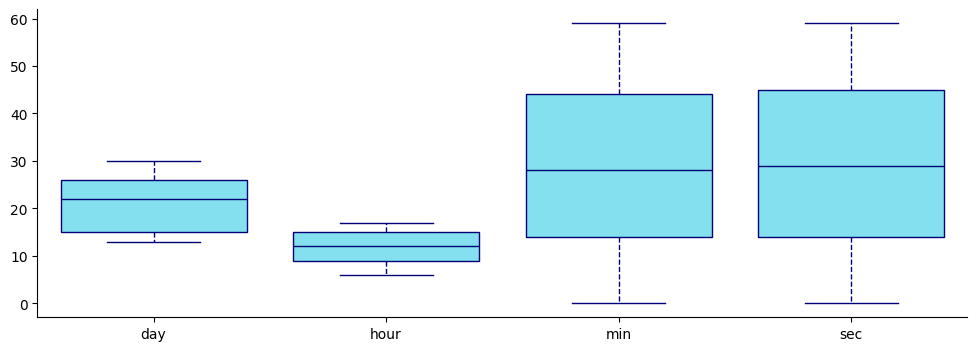

In [12]:
# Calcula estadísticas de recuento para cada variable
stats_df = df.loc[:,['day','hour','min','sec']]

# Crea un boxplot usando seaborn
plt.figure(figsize=(12, 4))
#sns.set(style="whitegrid")  # Estilo del fondo del gráfico

# Utiliza el método boxplot de seaborn con los datos y opciones adicionales
ax = sns.boxplot(data=stats_df, color=l_blue, 
            boxprops=dict(edgecolor=d_blue),
            whiskerprops=dict(color=d_blue, linestyle='--'),
            flierprops=dict(color=d_blue, markeredgecolor=d_blue),
            capprops=dict(color=d_blue),
            medianprops=dict(color=d_blue))
# Eliminar grid
#plt.grid(False

# Cambiar color del grid
ax.yaxis.grid(color=m_gray, linewidth=1.)

# Eliminar bordes de la figura
sns.despine()

# Cambiar color de las líneas de los ejes
ax.spines['bottom'].set_color('black')  # Color del eje x
ax.spines['left'].set_color('black')   # Color del eje y

# Eliminar la malla
ax.grid(False)

plt.show()

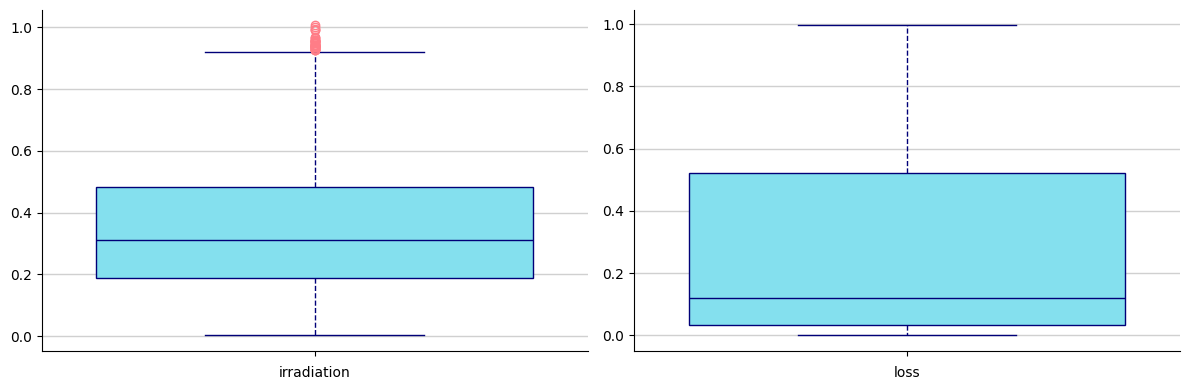

In [13]:
# Crear una figura y ejes con dos filas y una columna
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Gráfico en la primera fila
i_plot = sns.boxplot(data=df['irradiation'], color=l_blue, 
                    boxprops=dict(edgecolor=d_blue),
                    whiskerprops=dict(color=d_blue, linestyle='--'),
                    flierprops=dict(color=red, markeredgecolor=red),
                    capprops=dict(color=d_blue),
                    medianprops=dict(color=d_blue),
                    ax=axes[0])
axes[0].set_xlabel('irradiation')  # Etiqueta del eje x
axes[0].set_ylabel('')  # Quitar la etiqueta del eje y

# Gráficos en la segunda fila
l_plot = sns.boxplot(data=df['loss'], color=l_blue, 
                    boxprops=dict(edgecolor=d_blue),
                    whiskerprops=dict(color=d_blue, linestyle='--'),
                    flierprops=dict(color=red, markeredgecolor=red),
                    capprops=dict(color=d_blue),
                    medianprops=dict(color=d_blue),
                    ax=axes[1])
axes[1].set_xlabel('loss')  # Etiqueta del eje x
axes[1].set_ylabel('')  # Quitar la etiqueta del eje y

# Cambiar color del grid
i_plot.yaxis.grid(color=m_gray, linewidth=1.)
l_plot.yaxis.grid(color=m_gray, linewidth=1.)

# Cambiar color de las líneas de los ejes
i_plot.spines['bottom'].set_color('black')  # Color del eje x
i_plot.spines['left'].set_color('black')   # Color del eje y
l_plot.spines['bottom'].set_color('black')  # Color del eje x
l_plot.spines['left'].set_color('black')   # Color del eje y

# Eliminar bordes de la figura
sns.despine()

# Ajustar el diseño
plt.tight_layout()

# Mostrar los gráficos
plt.show()

#### Perdidas e irradiación promedio por dia

In [14]:
# Función para ocultar lineas de marco
def hide_frames(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

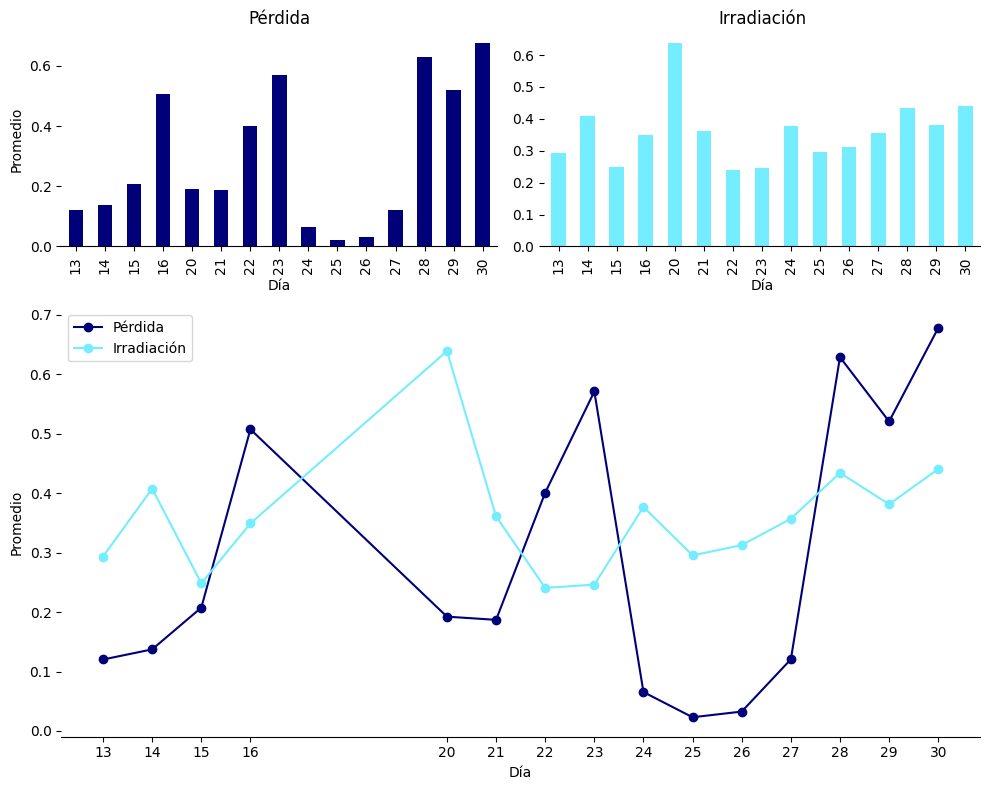

In [15]:
# Crear la figura y los subplots con gridspec
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 2])

# Primera fila, primera columna
ax1 = plt.subplot(gs[0, 0])
mean_loss_per_day = df.groupby('day').loss.mean()
mean_loss_per_day.plot.bar(color=d_blue)
ax1.set_title('Pérdida')
ax1.set_ylabel('Promedio')
ax1.set_xlabel('Día')
ax1.grid(False)
hide_frames(ax1)

# Primera fila, segunda columna
ax2 = plt.subplot(gs[0, 1])
mean_irradiation_per_day = df.groupby('day').irradiation.mean()
mean_irradiation_per_day.plot.bar(color=l_blue)
ax2.set_title('Irradiación')
ax2.set_xlabel('Día')
ax2.grid(False)
hide_frames(ax2)

# Segunda fila, gráfica centrada
days = list(set(df['day']))
ax3 = plt.subplot(gs[1, :])
ax3.plot(days, mean_loss_per_day,
         label='Pérdida', marker='o', color=d_blue)
ax3.plot(days, mean_irradiation_per_day,
         label='Irradiación', marker='o', color=l_blue)
ax3.set_xlabel('Día')
ax3.set_ylabel('Promedio')
ax3.legend()
ax3.set_xticks(days)
ax3.grid(False)
hide_frames(ax3)

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Mostrar las gráficas
plt.show()

#### Perdidas e irradiación promedio por hora

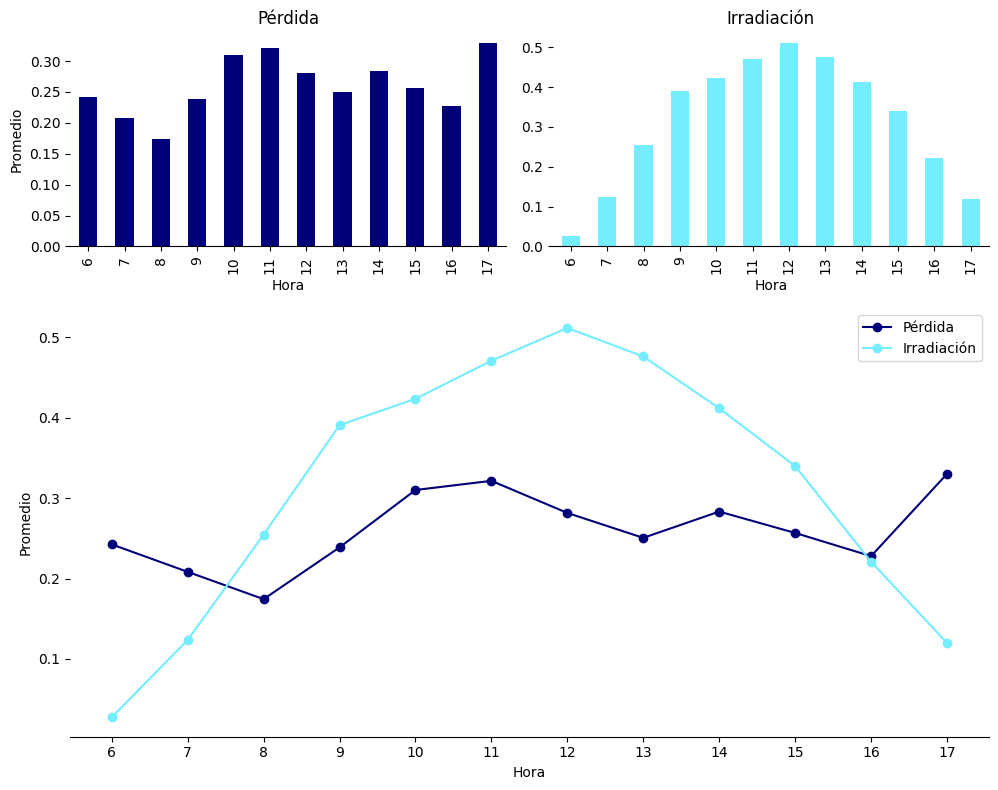

In [16]:
# Primero convertimos las horas a entero para trabajar más fácil
df['hour'] = df['hour'].astype('int')

# Crear la figura y los subplots con gridspec
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 2])

# Primera fila, primera columna
ax1 = plt.subplot(gs[0, 0])
mean_loss_per_hour = df.groupby('hour').loss.mean()
mean_loss_per_hour.plot.bar(color=d_blue)
ax1.set_title('Pérdida')
ax1.set_ylabel('Promedio')
ax1.set_xlabel('Hora')
ax1.grid(False)
hide_frames(ax1)

# Primera fila, segunda columna
ax2 = plt.subplot(gs[0, 1])
mean_irradiation_per_hour = df.groupby('hour').irradiation.mean()
mean_irradiation_per_hour.plot.bar(color=l_blue)
ax2.set_title('Irradiación')
ax2.set_xlabel('Hora')
ax2.grid(False)
hide_frames(ax2)

# Segunda fila, gráfica centrada
hours = list(set(df['hour']))
ax3 = plt.subplot(gs[1, :])
ax3.plot(hours, mean_loss_per_hour,
         label='Pérdida', marker='o', color=d_blue)
ax3.plot(hours, mean_irradiation_per_hour,
         label='Irradiación', marker='o', color=l_blue)
ax3.set_xlabel('Hora')
ax3.set_ylabel('Promedio')
ax3.legend()
ax3.set_xticks(hours)
ax3.grid(False)
hide_frames(ax3)

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Mostrar las gráficas
plt.show()

#### Pérdidas e irradiación por fecha

In [17]:
irradiation_per_date = df['irradiation'].tolist()
loss_per_date = df['loss'].tolist()
date_plot = list(range(len(df['loss'])))
len(date_plot)

45754

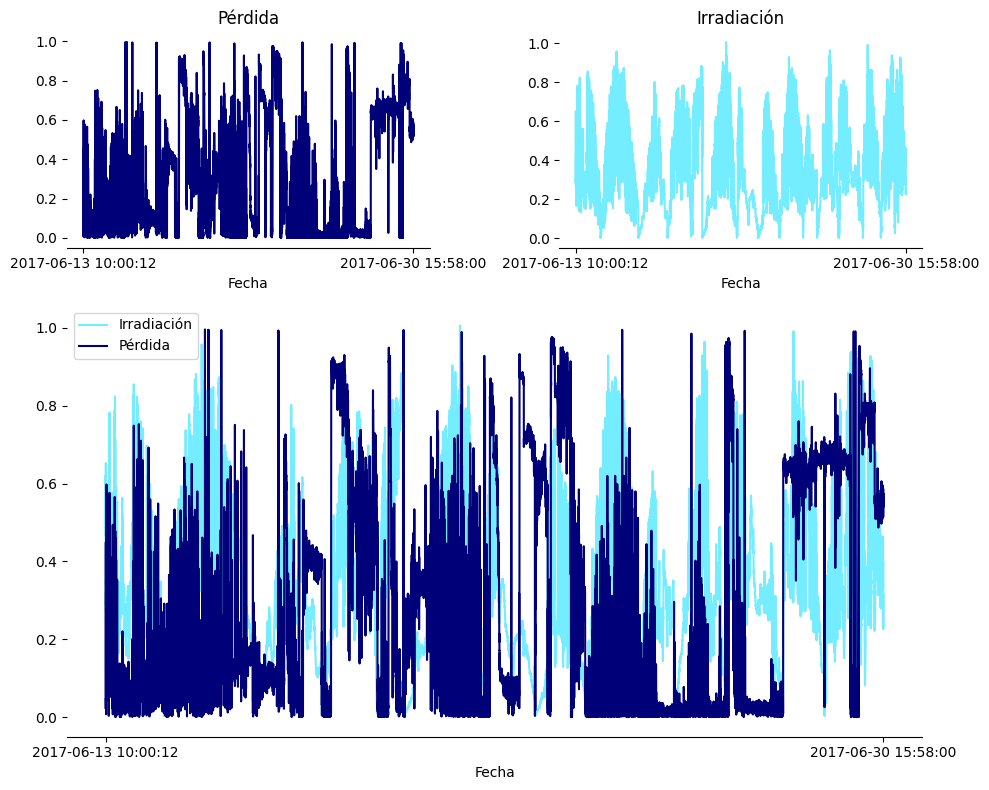

In [18]:
# Primero convertimos las horas a entero para trabajar más fácil
df['hour'] = df['hour'].astype('int')

# Crear la figura y los subplots con gridspec
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 2])

# Primera fila, primera columna
ax1 = plt.subplot(gs[0, 0])
ax1.plot(loss_per_date, color=d_blue)
ax1.set_xticks([0, len(date_plot) - 1])  # Primer y último índice
ax1.set_xticklabels([df['date'][0], df['date'].iloc[-1]])
ax1.set_title('Pérdida')
ax1.set_xlabel('Fecha')
ax1.grid(False)
hide_frames(ax1)

# Primera fila, segunda columna
ax2 = plt.subplot(gs[0, 1])
ax2.plot(irradiation_per_date, color=l_blue)
ax2.set_xticks([0, len(date_plot) - 1])  # Primer y último índice
ax2.set_xticklabels([df['date'][0], df['date'].iloc[-1]])
ax2.set_title('Irradiación')
ax2.set_xlabel('Fecha')
ax2.grid(False)
hide_frames(ax2)

# Segunda fila, gráfica centrada
ax3 = plt.subplot(gs[1, :])
ax3.plot(irradiation_per_date,
         label='Irradiación', color=l_blue)
# ax3.fill_between(range(len(date_plot)), irradiation_per_date, color=l_blue, alpha=0.4, label='Área bajo la curva')
ax3.plot(loss_per_date,
         label='Pérdida', color=d_blue)
ax3.set_xticks([0, len(date_plot) - 1])  # Primer y último índice
ax3.set_xticklabels([df['date'][0], df['date'].iloc[-1]])
ax3.set_xlabel('Fecha')
ax3.grid(False)
ax3.legend()
hide_frames(ax3)

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Mostrar las gráficas
plt.show()

#### Correlación entre variables

In [19]:
# Función para ocultar lineas de marco
def hide_frames(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [20]:
numerical_vars = ['day', 'time', 'loss', 'irradiation']

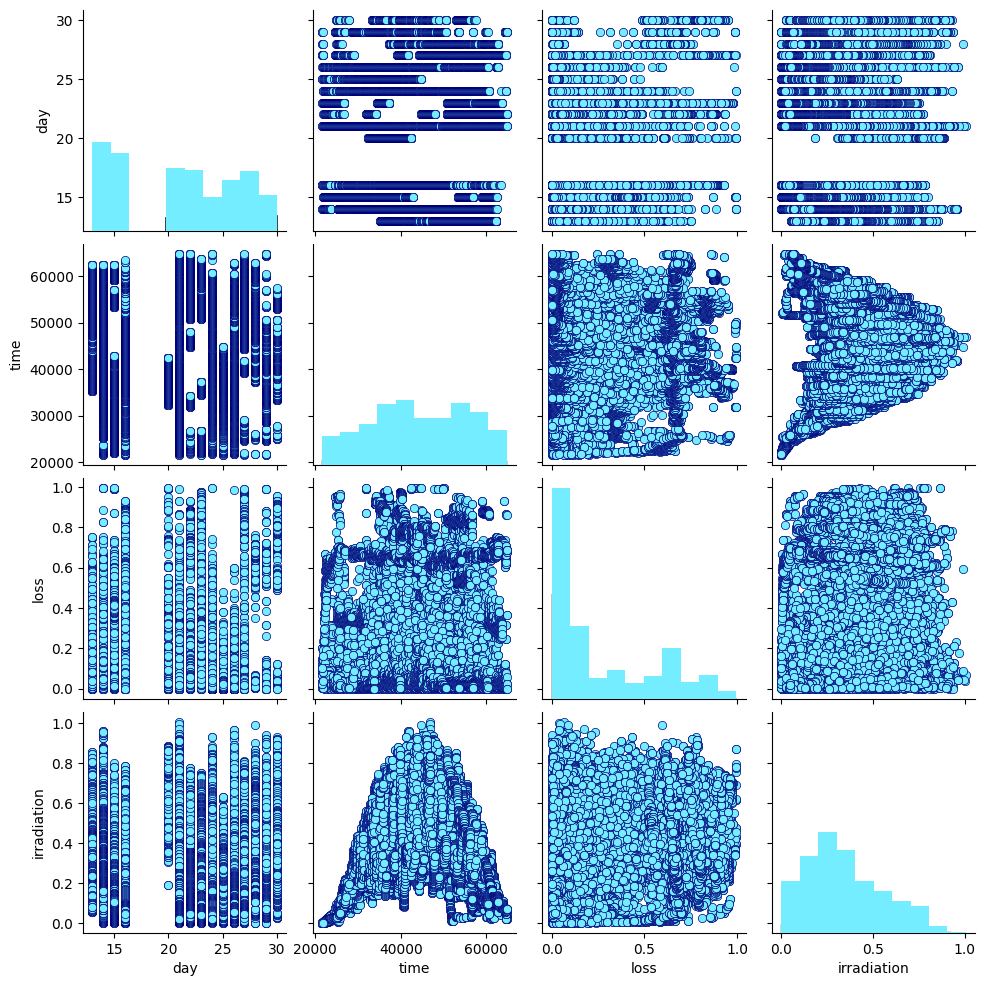

In [21]:
# Crear diagramas de dispersión entre todas las columnas
g = sns.pairplot(df[numerical_vars])
g.map_upper(sns.scatterplot,color=l_blue, edgecolor=d_blue)
g.map_lower(sns.scatterplot, color=l_blue, edgecolor=d_blue)
g.map_diag(plt.hist, color=l_blue)

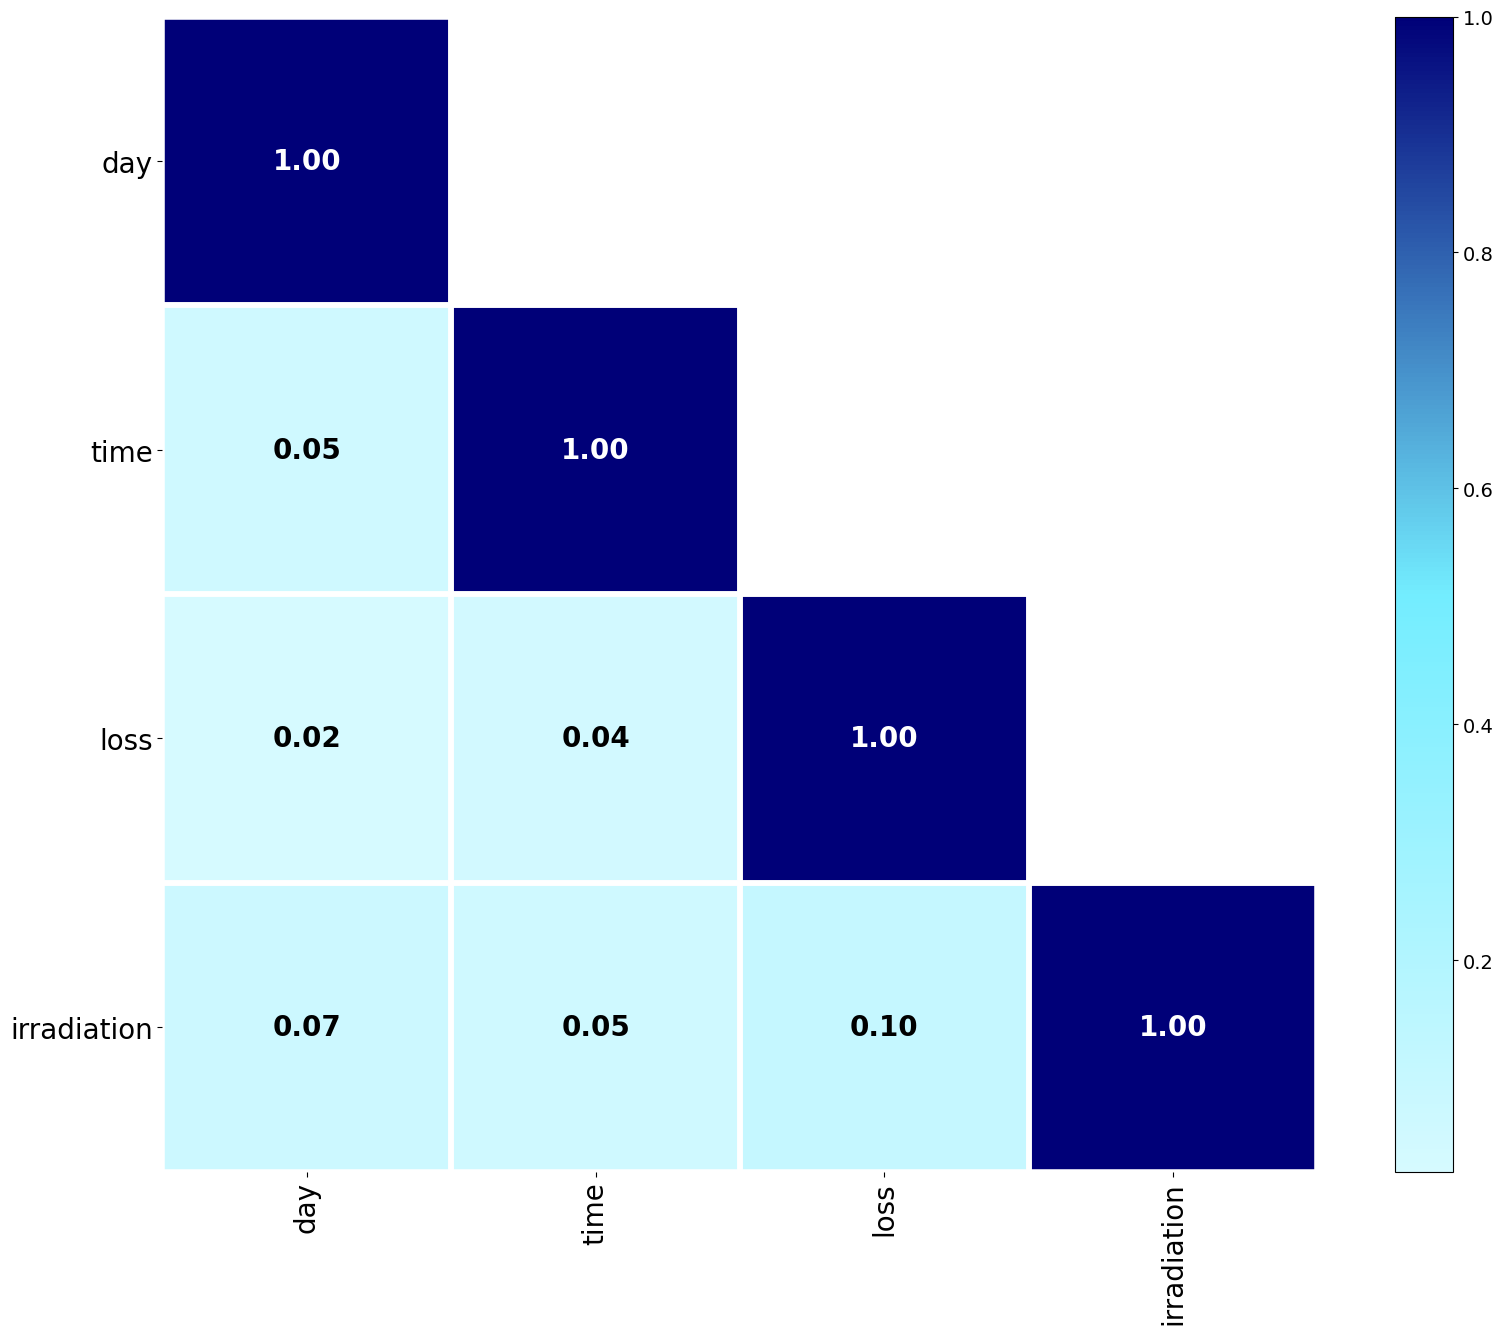

In [22]:
corr_vars = numerical_vars
corr = df.loc[:,corr_vars].corr(method='spearman')

# Obtener los índices de los elementos por encima de la diagonal
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)

# Establecer a NaN los elementos por encima de la diagonal
corr = corr.mask(mask)

# Creación de un colormap personalizado
colormap = LinearSegmentedColormap.from_list('custom',
                                             [(0, s_l_blue),
                                              (0.5, l_blue),
                                              (1, d_blue)], N=256)

f = plt.figure(figsize=(20, 15))
plt.imshow(corr, interpolation='nearest', cmap=colormap)

# Personalizar los bordes de los cuadraditos
for i in range(len(numerical_vars)):
    for j in range(len(numerical_vars)):
        edge_color = 'white'
        plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False,
                                          edgecolor=edge_color, linewidth=4))

plt.xticks(range(df[numerical_vars].shape[1]), df[numerical_vars].columns, fontsize=20, rotation=90)
plt.yticks(range(df[numerical_vars].shape[1]), df[numerical_vars].columns, fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

# Añadir texto del valor de correlación 
for i in range(len(numerical_vars)):
    for j in range(len(numerical_vars)):
        if not np.isnan(corr.iloc[i, j]):
            if i != j:
                color = 'k'
            else:
                color = 'w'
            plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', 
                     color=color, weight='bold',fontsize=20)

plt.box(False)

## Guardar dataframe para el modelado

In [33]:
df.loc[:,['filename', 'time', 'irradiation', 'loss']].to_csv('data_for_models.csv', encoding='utf-8', index=False)